# Two approaches for defining a collocation method

The collocation method solves the Dahlquist problem by solving the Picard form of the ODE :

$$u(t_1) = u(t_0) + \int_{t_0}^{t_1} \lambda u(\tau)d\tau$$

using a quadrature rule on some (normalized) nodes $\tau_1, ..., \tau_M \in [0, 1]$ to approximate the integral.

Those nodes can be all strictly contained in $[0,1]$ ($\tau_1 > 0$, $\tau_M < 1$ => GAUSS), include only the left boundary ($\tau_1 = 0$, $\tau_M < 1$ => RADAU-I), include only the right boundary ($\tau_1 > 0$, $\tau_M = 1$ => RADAU-II) or both ($\tau_1 = 0$, $\tau_M = 1$ => LOBATTO). Those four approaches define a given _quadrature type_, that can be simply considered as an additional parameter of the collocation method.

Now using the quadrature rule we obtain a discrete equation for the solution on each nodes :

$$u(\tau_m) = u(t_0) + \int_{t_0}^{\tau_m} \lambda u(\tau)d\tau$$

and combining all of them in algebraic form gives :

$$(I-\lambda\Delta{t}Q) 
\begin{pmatrix} u(\tau_1)\\ \vdots\\  u(\tau_M) \end{pmatrix}
= \begin{pmatrix} u(t_0)\\ \vdots\\  u(t_0) \end{pmatrix},$$

with $\Delta{t}=t_1-t_0$.

> Now the problem is : depending on wether or not $\tau_M = 1$, we need to find a generic way to compute $u(t_1)$ in order to compute the next time-step (where the current $u(t_1)$ will become the next $u(t_0)$).

To do that, there is two approaches.

**First approach : use a polynomial extrapolation**

Once we have computed the solution at each nodes $\tau_1, ..., \tau_M$, it is like we approximated the solution on $[t_0, t_1]$ using a polynomial represented on $M$ points, *i.e* of order $M-1$.
So we can simply evaluate this polynomial on the last point $t_1$ to get the end-point solution.
This gives us a formula of the form :

$$u(t_1) = \sum_{i=1}^{M} c_i u(\tau_i),$$

where the $c_i$ depends only on the node distribution (and can be computed, for instance, using barycentric interpolation). This gives us a matrix

$$H = 
\begin{pmatrix} 
c_1 & \dots & c_M \\
\vdots & & \vdots \\
c_1 & \dots & c_M \\
\end{pmatrix}$$

such that

$$(I-\lambda\Delta{t}Q) \begin{pmatrix} u(\tau_1)\\ \vdots\\  u(\tau_M) \end{pmatrix} 
= H \begin{pmatrix} u_{prev}(\tau_1)\\ \vdots\\  u_{prev}(\tau_M) \end{pmatrix}$$

where $u_{prev}$ is the solution from the previous time-step interval.

In particular, if $\tau_m=1$, then we have naturally $u(t_1)=u(\tau_m)$ and we can simply copy the value, so the $H$ matrix is simply :

$$H = 
\begin{pmatrix} 
0 & \dots & 0 & 1 \\
\vdots & & \vdots & \vdots \\
0 & \dots & 0 & 1\\
\end{pmatrix}$$

Now, we have our collocation method within the GFM framework with the block vector $\begin{pmatrix} u(\tau_1), \dots,  u(\tau_M) \end{pmatrix}^T$, and

$$
\phi = (I-\lambda\Delta{t}Q), \quad
\chi = H,
$$

and the end-point solution from each interval can be retrieved by taking any element (for instance, first one) of the following vector :

$$
\chi \begin{pmatrix} u_{prev}(\tau_1)\\ \vdots\\  u_{prev}(\tau_M) \end{pmatrix}
$$


**Second approach : use a collocation formula**

Once we have computed the solution at each nodes $\tau_1, ..., \tau_M$, we can also use the discrete Picard form to compute the end-point solution (at the expense of computing again an approximate quadrature) :

$$u(t_1) = u(t_0) + \int_{t_0}^{t_1} \lambda u(\tau)d\tau$$

Here instead of approximating the solution by a polynomial, we approximate the integral instead using the quadrature rule defined by the nodes :

$$u(t_1) = u(t_0) + \sum_{i=1}^{M} \omega_i u(\tau_i),$$

with $\omega_i$ the quadrature weights that can be computed directly from the nodes (for instance, by integrating the Lagrange interpolating polynomials, or simply by getting the Gauss quadrature rule).

Here we need $u(t_0)$, which implies that $u(t_1)$ must be considered as an unknown of the collocation problem, similarly as any other $u(\tau_i)$.
So our block vector is then $\begin{pmatrix} u(\tau_1), \dots,  u(\tau_M), u(t_1) \end{pmatrix}^T$ and **necessarily include the end-point solution, independent from the quadrature type** (that is, even if we use GAUSS points !).

This implies that 

$$\chi = 
\begin{pmatrix} 
0 & \dots & 0 & 1 \\
\vdots & & \vdots & \vdots \\
0 & \dots & 0 & 1\\
\end{pmatrix}$$

and 

$$
\phi = \begin{pmatrix} 
(I-\lambda\Delta{t}Q) & 0 \\
-\lambda\delta{t}{\bf w} & 1
\end{pmatrix}
$$

with ${\bf w} = (\omega_1, \dots, \omega_M)$

Note that with $M$ nodes, we get now $(M+1) \times (M+1)$ matrices for the block operators.

> **Question : if we use both approaches to integrate the Dahlquist problem with a given number of quadrature nodes $M$, what is the order of accuracy in function of $M$ and the quadrature type (GAUSS, LOBATTO, ...) ?**

In [1]:
# Script import setup
import numpy as np
import matplotlib.pyplot as plt
from gfm.base import GFMSolver
plt.rcParams['figure.dpi'] = 100

Let's define a function below that computes the global truncation error on a given interval $[0,T]$, with default value for $T=2\pi$, and $\lambda=i$.
The main parameters are :

- M : number of quadrature nodes
- qType : quadrature type (`GAUSS`, `LOBATTO`, ...)
- nodes : node distribution (`LEGENDRE`, `CHEBYCHEV`, `EQUID`, ...)
- exactProlong : wether or not using "exact prolongation" with collocation formula (second approach) or polynomial interpolation (first approach)

In [2]:
def getCollocationError(M, qType, nodes, T=2*np.pi, lam=1j, exactProlong=False):
    err = []
    lDt = []
    
    for l in [1, 2, 4, 8, 16, 32]:
        # Compute time step size
        dt = T/l
        lDt.append(dt)
        # Set up the collocation solver
        solver = GFMSolver(lam=lam, u0=1, dt=dt, L=l)
        if exactProlong:
            # Use exact prolongation for the end point
            # => artificially add end-point to the quadrature nodes => M += 1
            solver.setFineLevel(M=M+1, method='COLLOCATION', qType=qType, nodes=nodes, exactProlong=True)
        else:
            # Don't use exact prolongation for the end point
            solver.setFineLevel(M=M, method='COLLOCATION', qType=qType, nodes=nodes)
        # Compute end time solution for collocation, using the chi operator applied on the last block vector
        uEndNum = (solver.chi @ solver.uFine[-1])[0]
        # Compute end time exact solution using exponential
        uEndExact = np.exp(T*lam)
        # Store error
        err.append(abs(uEndExact-uEndNum))
        
    return err, lDt, solver # returns the solver object for post processing, just in case ...

Now lets look at the first approach (exactProlong=False, default value) for Legendre nodes and each of the four quadrature types :

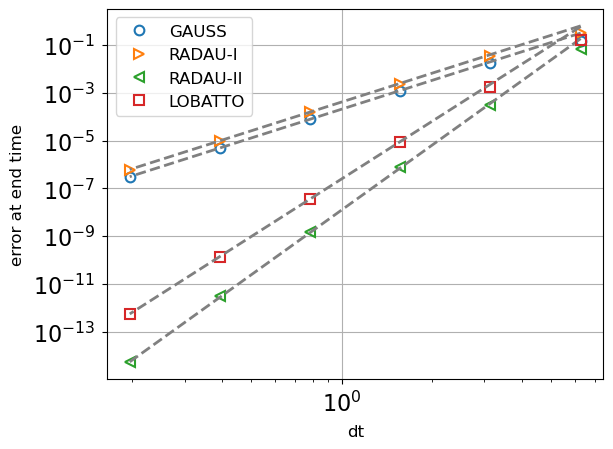

In [3]:
nodes = 'LEGENDRE'
M = 5
for qType, order, sym in zip(['GAUSS', 'RADAU-I', 'RADAU-II', 'LOBATTO'], 
                             [M-1, M-1, 2*M-1, 2*M-2],  # Respective orders of accuracy
                             ['o', '>', '<', 's']):
    err, lDt, solver = getCollocationError(M=M, qType=qType, nodes=nodes)
    plt.loglog(lDt, err, sym, label=qType)
    lDt = np.array(lDt)
    c = err[-1]/lDt[-1]**order
    plt.plot(lDt, c*lDt**order, '--', color='gray')

plt.legend()
plt.xlabel('dt')
plt.ylabel('error at end time')
plt.grid()

We can see the following order of accuracy depending on the quadrature type :

- `GAUSS` and `RADAU-I` : order $M-1$
- `RADAU-II` : order $2M-1$
- `LOBATTO` : order $2M-2$

The result for GAUSS and RADAU-I is actually not surprising : since we use a barycentric interpolation of order $M-1$ to compute the end point, this limits the accuracy of the time-stepping method.

For `LOBATTO` and `RADAU-II`, this is however different : we don't really use a barycentric interpolation of order $M-1$, because by copying the end-point value we actually use an "exact" interpolation. So the limiting accuracy is the one of the quadrature rule, and since we used LEGENDRE nodes, we retrieve the expected order of accuracy for `LOBATTO` and `RADAU-II` nodes.

Is it the same with the second approach ? Let just store the error for `LOBATTO` here, and go back at it later ...

In [4]:
err1 = err

Now lets look at the second approach (exactProlong=True) for Legendre nodes and each of the four quadrature types :

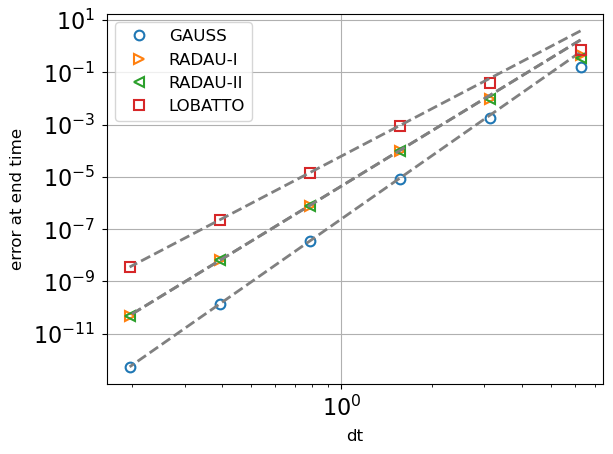

In [5]:
nodes = 'LEGENDRE'
M = 4
for qType, order, sym in zip(['GAUSS', 'RADAU-I', 'RADAU-II', 'LOBATTO'], 
                             [2*M, 2*M-1, 2*M-1, 2*M-2],  # Respective orders of accuracy
                             ['o', '>', '<', 's']):
    err, lDt, solver = getCollocationError(M=M, qType=qType, nodes=nodes, exactProlong=True)
    plt.loglog(lDt, err, sym, label=qType)
    lDt = np.array(lDt)
    c = err[-1]/lDt[-1]**order
    plt.plot(lDt, c*lDt**order, '--', color='gray')

plt.legend()
plt.xlabel('dt')
plt.ylabel('error at end time')
plt.grid()

Now we retrieve the expected order of accuracy for each quadrature type, that is :

- `GAUSS` : order $2M$
- `RADAU-I` and `RADAU-II` : order $2M-1$
- `LOBATTO` : order $2M-2$

In particular, we get the same order of accuracy for `LOBATTO` and `RADAU-II`, independent of the used approach to compute the end-point value.
Also, if we store the last error we have for `LOBATTO`, compare with what we had for the first approach :

In [6]:
err2 = err
[abs(e1-e2) for e1, e2 in zip(err1, err2)]

[0.5216165293010738,
 0.03799420143249918,
 0.0008408401334560849,
 1.4247248696022871e-05,
 2.2709392608402718e-07,
 3.565997835664647e-09]

We retrieve exactly the same error up to machine precision, which indicates that the two approaches are equivalent when the last node coincide with the end-point.

This is actually not hard to prove theoretically. If we look at the two last lines of the following system :

$$
\begin{pmatrix} 
(I-\lambda\Delta{t}Q) & 0 \\
-\lambda\delta{t}{\bf w} & 1
\end{pmatrix}\begin{pmatrix} u(\tau_{i}) \\ u(t_1) \end{pmatrix}
= \begin{pmatrix} u(t_0) \\ u(t_0) \end{pmatrix}
$$

we get

$$
u(t_M) - \lambda\sum_{i=1}^{M} q_{M,i} u(\tau_i) = u(t_0) 
\\
u(t_1) - \lambda\sum_{i=1}^{M} \omega_i u(\tau_i) = u(t_0) 
$$

Since $t_M=t_1$, then the integral up to this node is actually the integral for the whole interval, hence we simply get the standard quadrature rule, _i.e_ $q_{M,i}=\omega_i$. 
Now substracting both equation leads to

$$ u(t_M) = u(t_1) $$

so the solution $u(t_M)$ of the collocation problem coincides with the initial value for the next interval, so the last line of the system can be removed to get back the formulation of the first approach.

## Additional comments

For now we only considered `LEGENDRE` node distribution for the analysis. What if we change the node distribution, and then have a different collocation accuracy ?

Let us consider the same tests as before, but this time with equidistant nodes. Those can also be defined for `GAUSS`, `RADAU-I`, `RADAU-II` and `LOBATTO` quadrature type the following way :

```python
nodes = np.linspace(0, 1, M+1)[1:] if qType == 'RADAU-II' else \
    np.linspace(0, 1, M+1)[:-1] if qType == 'RADAU-I' else \
    np.linspace(0, 1, M+2)[1:-1] if qType == 'GAUSS' else \
    np.linspace(1, 0, M)[-1::-1]  # LOBATTO, with tau=1 for M=1
```

For instance, the equidistant points with "`GAUSS` quadrature type" simply correspond to uniformly distributed points between `[0,1]` that don't include left and right boundary. Now running this for the first type of collocation method (first approach, using polynomial extrapolation) provide the following results :

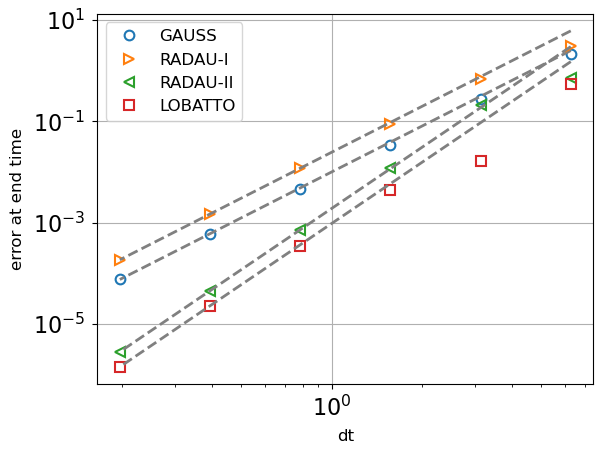

In [7]:
nodes = 'EQUID'
M = 4
for qType, order, sym in zip(['GAUSS', 'RADAU-I', 'RADAU-II', 'LOBATTO'], 
                             [M-1, M-1, M, M],  # Respective orders of accuracy
                             ['o', '>', '<', 's']):
    err, lDt, solver = getCollocationError(M=M, qType=qType, nodes=nodes)
    plt.loglog(lDt, err, sym, label=qType)
    lDt = np.array(lDt)
    c = err[-1]/lDt[-1]**order
    plt.plot(lDt, c*lDt**order, '--', color='gray')

plt.legend()
plt.xlabel('dt')
plt.ylabel('error at end time')
plt.grid()

As before, we observe that the collocation accuracy with `GAUSS` or `RADAU-I` nodes is of order $M-1$ because we used the polynomial extrapolation, which is of order $M-1$. This is not the case for `RADAU-II` and `LOBATTO`, as we retrive for them the expected $M$ order accuracy from the quadrature rule.

Now switching to the second approach that uses the collocation update ("exact prolongation"), we retrieve the expected accuracy order uniform quadrature formula, that is order $M$ for every quadrature type :

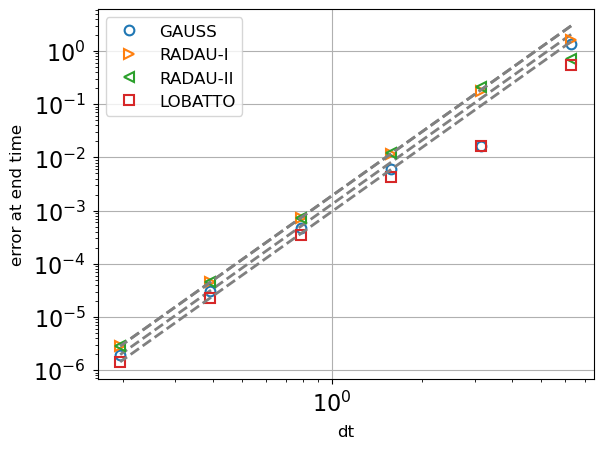

In [8]:
nodes = 'EQUID'
M = 4
for qType, order, sym in zip(['GAUSS', 'RADAU-I', 'RADAU-II', 'LOBATTO'], 
                             [M, M, M, M],  # Respective orders of accuracy
                             ['o', '>', '<', 's']):
    err, lDt, solver = getCollocationError(M=M, qType=qType, nodes=nodes, exactProlong=True)
    plt.loglog(lDt, err, sym, label=qType)
    lDt = np.array(lDt)
    c = err[-1]/lDt[-1]**order
    plt.plot(lDt, c*lDt**order, '--', color='gray')

plt.legend()
plt.xlabel('dt')
plt.ylabel('error at end time')
plt.grid()

## But here is a weird thing ...

Did you know : the expected order of accuracy for also depends on the number of collocation points. For now we only used an even number of nodes, that is $M=4$. But let us change that, and consider for instance $M=5$, using the first approach (polynomial interpolation) to compute the end value. With equidistant points, we get the following results :

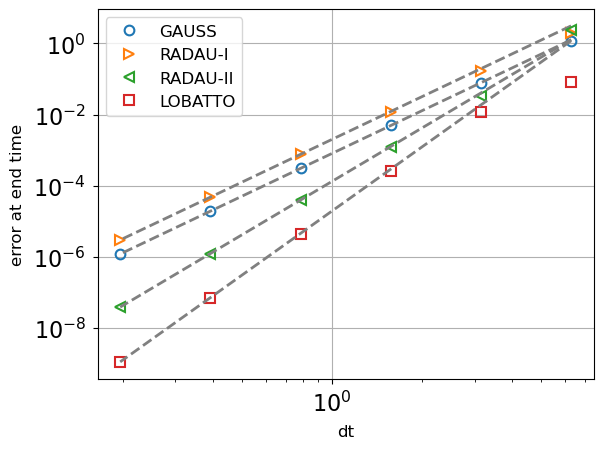

In [9]:
nodes = 'EQUID'
M = 5
for qType, order, sym in zip(['GAUSS', 'RADAU-I', 'RADAU-II', 'LOBATTO'], 
                             [M-1, M-1, M, M+1],  # Respective orders of accuracy
                             ['o', '>', '<', 's']):
    err, lDt, solver = getCollocationError(M=M, qType=qType, nodes=nodes)
    plt.loglog(lDt, err, sym, label=qType)
    lDt = np.array(lDt)
    c = err[-1]/lDt[-1]**order
    plt.plot(lDt, c*lDt**order, '--', color='gray')

plt.legend()
plt.xlabel('dt')
plt.ylabel('error at end time')
plt.grid()

As before, we get order $M-1$ for both `GAUSS` and `RADAU-I` quadrature types, because of the polynomial interpolation. Then order of accuracy $M$ for `RADAU-II` as expected, since the interpolation formula actually uses collocation update formula (_c.f_ before). But for some reason (that I completely ignore, to be honest), **using uniform points with `LOBATTO` quadrature type provides an accuracy of order $M+1$ !**

And if we switch to the second approach (using collocation update, _i.e_ "exact prolongation"), then we get order $M$ for `RADAU-I` and `RADAU-II` (as expected), but **we also get order $M+1$ for `LOBATTO` and `GAUSS` quadrature type too !**

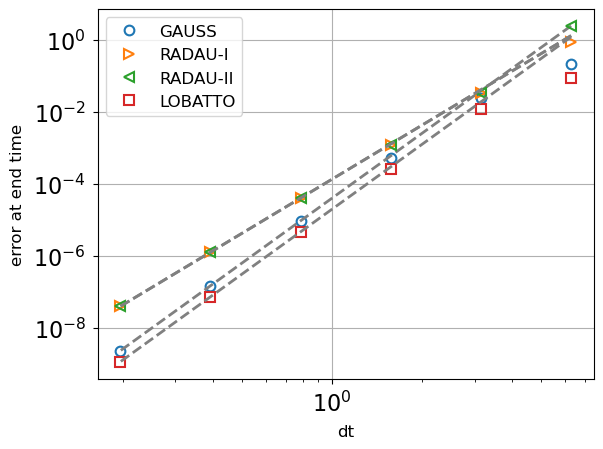

In [10]:
nodes = 'EQUID'
M = 5
for qType, order, sym in zip(['GAUSS', 'RADAU-I', 'RADAU-II', 'LOBATTO'], 
                             [M+1, M, M, M+1],  # Respective orders of accuracy
                             ['o', '>', '<', 's']):
    err, lDt, solver = getCollocationError(M=M, qType=qType, nodes=nodes, exactProlong=True)
    plt.loglog(lDt, err, sym, label=qType)
    lDt = np.array(lDt)
    c = err[-1]/lDt[-1]**order
    plt.plot(lDt, c*lDt**order, '--', color='gray')

plt.legend()
plt.xlabel('dt')
plt.ylabel('error at end time')
plt.grid()

This seems be conditioned to the fact that $M$ is even or not, as we observe also it for $M=3$ :

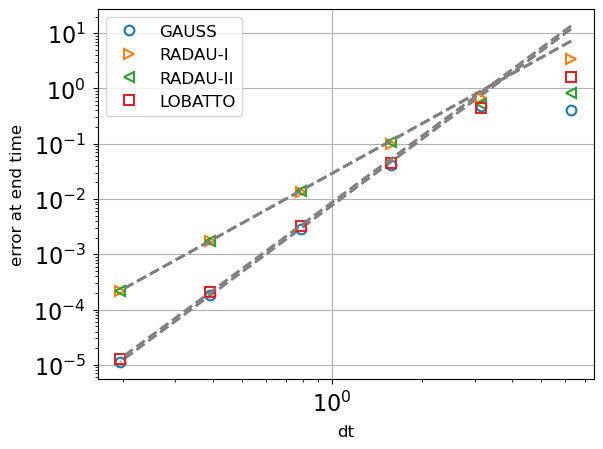

In [11]:
nodes = 'EQUID'
M = 3
for qType, order, sym in zip(['GAUSS', 'RADAU-I', 'RADAU-II', 'LOBATTO'], 
                             [M+1, M, M, M+1],  # Respective orders of accuracy
                             ['o', '>', '<', 's']):
    err, lDt, solver = getCollocationError(M=M, qType=qType, nodes=nodes, exactProlong=True)
    plt.loglog(lDt, err, sym, label=qType)
    lDt = np.array(lDt)
    c = err[-1]/lDt[-1]**order
    plt.plot(lDt, c*lDt**order, '--', color='gray')

plt.legend()
plt.xlabel('dt')
plt.ylabel('error at end time')
plt.grid()

But this does not apply when we use `LEGENDRE` nodes, as we can see here in this example exact prolongation (collocation update) and $M=5$ :

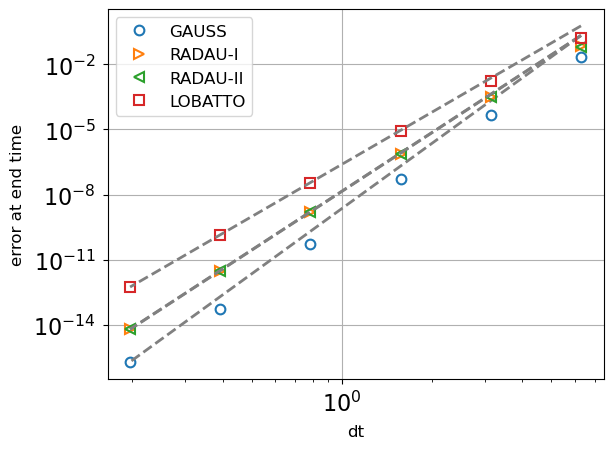

In [12]:
nodes = 'LEGENDRE'
M = 5
for qType, order, sym in zip(['GAUSS', 'RADAU-I', 'RADAU-II', 'LOBATTO'], 
                             [2*M, 2*M-1, 2*M-1, 2*M-2],  # Respective orders of accuracy
                             ['o', '>', '<', 's']):
    err, lDt, solver = getCollocationError(M=M, qType=qType, nodes=nodes, exactProlong=True)
    plt.loglog(lDt, err, sym, label=qType)
    lDt = np.array(lDt)
    c = err[-1]/lDt[-1]**order
    plt.plot(lDt, c*lDt**order, '--', color='gray')

plt.legend()
plt.xlabel('dt')
plt.ylabel('error at end time')
plt.grid()